<a href="https://colab.research.google.com/github/ksy-20908/godoheon/blob/main/%EC%B6%A9%EB%82%A8%EB%8C%80_%EB%B0%B0%EC%9E%AC%EB%8C%80_AI_%EB%94%A5%EB%9F%AC%EB%8B%9D_8%EC%A3%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install tensorflow_io

     |████████████████████████████████| 22.3MB 72.7MB/s 


In [ ]:
# 도구 준비
import os
import random
import math

import tensorflow as tf # 텐서플로우
import tensorflow_io as tfio
import matplotlib.pyplot as plt # 시각화 도구
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split

from IPython.display import Audio


print(f'Tensorflow 버전을 확인합니다: {tf.__version__}')

Tensorflow 버전을 확인합니다: 2.3.0


In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print(f'Google colab 환경이 아닙니다.')
    pass

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!rm -r /tmp/data_speech_commands &> /dev/null
!mkdir /tmp/data_speech_commands
!tar --directory /tmp/data_speech_commands -xvf '/content/gdrive/My Drive/Colab Notebooks/data_speech_commands_v0.02.tar.gz' &> /dev/null
!rm -r /tmp/data_speech_commands/_background_noise_
!ls /tmp/data_speech_commands


backward  five	   learn    on	       stop		    visual
bed	  follow   left     one        testing_list.txt     wow
bird	  forward  LICENSE  README.md  three		    yes
cat	  four	   marvin   right      tree		    zero
dog	  go	   nine     seven      two
down	  happy    no	    sheila     up
eight	  house    off	    six        validation_list.txt


In [ ]:
path_root = '/tmp/data_speech_commands'

files = list()
labels = list()
lab2idx = list()
for l1 in os.scandir(path_root):
    if l1.is_file():
        continue
    label = os.path.basename(l1.path)
    if label not in lab2idx:
        lab2idx.append(label)
    label_idx = lab2idx.index(label)
    for l2 in os.scandir(l1.path):
        files.append(l2.path)
        labels.append([label_idx])
dataset_root = (files, labels)
print(f'데이터 불러오기 완료: 파일 경로 {len(files)}개, 레이블 {len(lab2idx)}개')

데이터 불러오기 완료: 파일 경로 105829개, 레이블 35개


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(files, labels, test_size=0.2, shuffle=True)

In [ ]:
audio = tfio.audio.AudioIOTensor(x_test[0])
print(audio)
audio_tensor = tf.squeeze(audio.to_tensor(), axis=-1)
print(audio_tensor)

<AudioIOTensor: shape=[12631     1], dtype=<dtype: 'int16'>, rate=16000>
tf.Tensor([    0     0     0 ...  5306  1083 -2789], shape=(12631,), dtype=int16)


In [ ]:
printed = set()
for data, label in zip(x_test, y_test):
    label = label[0]
    if label in printed:
        continue
    print(lab2idx[label], end=': ')
    audio = tfio.audio.AudioIOTensor(data)
    audio_tensor = tf.squeeze(audio.to_tensor(), axis=-1)
    display(Audio(audio_tensor.numpy(), rate=audio.rate.numpy()))
    printed.add(label)

visual: 

on: 

no: 

bed: 

right: 

six: 

house: 

tree: 

cat: 

zero: 

sheila: 

left: 

eight: 

nine: 

wow: 

dog: 

four: 

one: 

backward: 

seven: 

down: 

stop: 

follow: 

three: 

learn: 

up: 

yes: 

two: 

go: 

marvin: 

off: 

forward: 

five: 

happy: 

bird: 

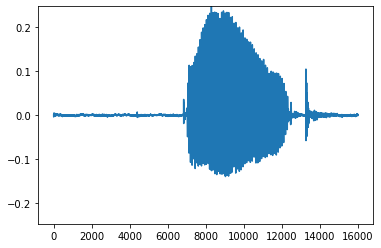

In [ ]:
tensor = tf.cast(audio_tensor, tf.float32) / 2**16

fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylim((-1*np.max(tensor), np.max(tensor)))
_ = ax.plot(tensor)

In [ ]:
def get_spectrogram(values):
    spectrogram = tfio.experimental.audio.spectrogram(tf.convert_to_tensor(values, dtype=tf.float32), 
                                                      nfft=512, window=512, stride=256)
    spectrogram = tf.transpose(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    spectrogram = tf.image.flip_up_down(spectrogram)
    
    return spectrogram

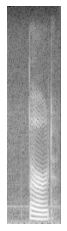

In [ ]:
spectrogram = get_spectrogram(audio_tensor.numpy())
spectrogram = tf.squeeze(spectrogram, -1)

fig = plt.figure()
ax = fig.add_subplot()
ax.axis('off')
_ = ax.imshow(tf.math.log(spectrogram.numpy()), cmap='gray')

In [ ]:
volume = 1.0
fs = 16000
duration = 1.0
f = 261.625

samples = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)
display(Audio(samples, rate=fs))

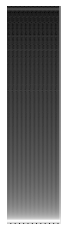

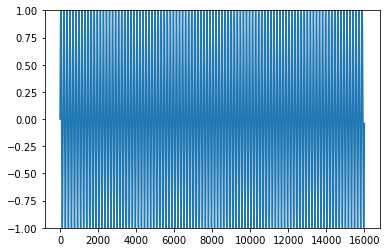

In [ ]:
# Convert to spectrogram
spectrogram = get_spectrogram(samples)
spectrogram = tf.squeeze(spectrogram, -1)

fig = plt.figure()
ax = fig.add_subplot()
ax.axis('off')
_ = ax.imshow(tf.math.log(spectrogram.numpy()), cmap='gray')
fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylim((-1*np.max(samples), np.max(samples)))
_ = ax.plot(samples)

In [ ]:
def load_audio(path, label):
    audio = tfio.audio.AudioIOTensor(path, dtype='int16')
    audio_tensor = tf.squeeze(audio.to_tensor(), axis=[-1])
    audio_tensor = tf.pad(tf.expand_dims(audio_tensor, 0), ((0, 0), (0, 16000)), 
                          'constant', constant_values=0)
    audio_tensor = tf.slice(audio_tensor, (0, 0), (1, 16000))
    audio_tensor = tf.squeeze(audio_tensor, axis=0)
    tensor = tf.cast(audio_tensor, tf.float32) / 2**16
    
    spectrogram = get_spectrogram(tensor)
    return spectrogram, label

In [ ]:
train_dataset_root = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset_root = tf.data.Dataset.from_tensor_slices((x_test, y_test))


train_dataset = train_dataset_root.map(load_audio)
val_dataset = val_dataset_root.map(load_audio)

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=get_spectrogram(samples).shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(lab2idx))
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 61, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 30, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 28, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 12, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 46080)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [ ]:
history = model.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
epochs = 10

history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset)

Epoch 1/10
2646/2646 [==============================] - 407s 154ms/step - loss: 1.1679 - sparse_categorical_accuracy: 0.6737 - val_loss: 0.6451 - val_sparse_categorical_accuracy: 0.8147
Epoch 2/10
2646/2646 [==============================] - 361s 137ms/step - loss: 0.5106 - sparse_categorical_accuracy: 0.8509 - val_loss: 0.5984 - val_sparse_categorical_accuracy: 0.8273
Epoch 3/10
2646/2646 [==============================] - 348s 131ms/step - loss: 0.3410 - sparse_categorical_accuracy: 0.8984 - val_loss: 0.5581 - val_sparse_categorical_accuracy: 0.8514
Epoch 4/10
2646/2646 [==============================] - 347s 131ms/step - loss: 0.2437 - sparse_categorical_accuracy: 0.9248 - val_loss: 0.6017 - val_sparse_categorical_accuracy: 0.8448
Epoch 5/10
2646/2646 [==============================] - 349s 132ms/step - loss: 0.1802 - sparse_categorical_accuracy: 0.9437 - val_loss: 0.7820 - val_sparse_categorical_accuracy: 0.8421
Epoch 6/10
2646/2646 [==============================] - 348s 132ms/ste

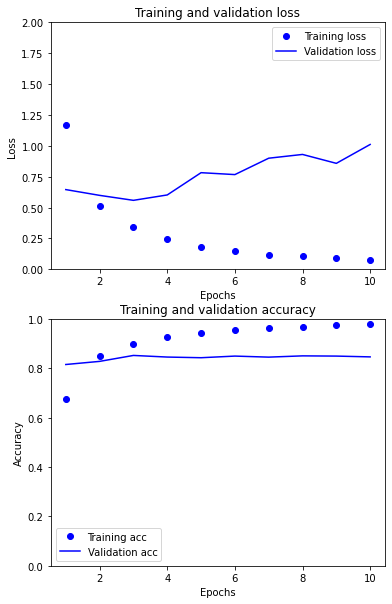

In [ ]:
history_dict = history.history
acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig1 = plt.figure(figsize=(6, 10))
ax = fig1.add_subplot(2, 1, 1)
ax.plot(epochs, loss, 'bo', label='Training loss')
ax.plot(epochs, val_loss, 'b', label='Validation loss')
ax.set_ylim((0, math.ceil(max(max(loss), max(val_loss)))))
ax.set_title('Training and validation loss', fontsize=12)
ax.set_xlabel('Epochs', fontsize=10)
ax.set_ylabel('Loss', fontsize=10)
ax.legend()

ax = fig1.add_subplot(2, 1, 2)
ax.plot(epochs, acc, 'bo', label='Training acc')
ax.plot(epochs, val_acc, 'b', label='Validation acc')
ax.set_ylim((0, math.ceil(max(max(acc), max(val_acc)))))
ax.set_title('Training and validation accuracy', fontsize=12)
ax.set_xlabel('Epochs', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend()

In [ ]:
print(f'레이블 종류: ')
for n, label in enumerate(lab2idx, start=1):
    print(label, end=' ')
    if n % 10 == 0:
        print()
print()

레이블 종류: 
eight nine wow down seven off learn happy bird bed 
backward no two three six five house visual sheila four 
stop follow cat one up right dog zero forward left 
tree on marvin go yes 


In [ ]:
test_label = 'happy'
test_idx = lab2idx.index(test_label)

target = list()
for path, label in zip(x_test, y_test):
    label = label[0]
    if label == test_idx:
        target.append((path, label))

choice = random.choice(target)
test_path = choice[0]

audio = tfio.audio.AudioIOTensor(test_path)
audio_tensor = tf.squeeze(audio.to_tensor(), axis=-1)
print(f'Label: {test_label} [{test_idx}]')
display(Audio(audio_tensor.numpy(), rate=audio.rate.numpy()))

Label: happy [7]


예측 레이블: happy


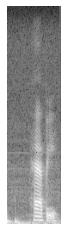

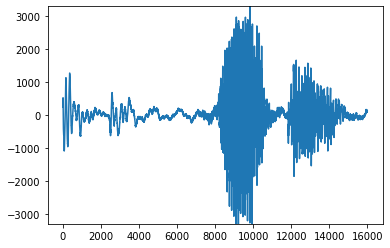

In [ ]:
spectrogram, _ = load_audio(test_path, test_label)
spectrogram_ = tf.squeeze(spectrogram, -1)

fig = plt.figure()
ax = fig.add_subplot()
ax.axis('off')
_ = ax.imshow(tf.math.log(spectrogram_.numpy()), cmap='gray')
fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylim((-1*np.max(audio_tensor.numpy()), np.max(audio_tensor.numpy())))
_ = ax.plot(audio_tensor.numpy())

print(f'예측 레이블: {lab2idx[np.argmax(model.predict(tf.expand_dims(spectrogram, 0)))]}')